## Skin Cancer MNIST HAM10000

In [166]:
#Import the necessary modules

import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
colors = sns.color_palette()

%matplotlib inline
plt.ion()   # interactive mode

import numpy as np
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

In [167]:
datadir = '/home/nishita/datasets/skin_mnist'

In [168]:
os.listdir(datadir) #list all files in dataset dir

['hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'hmnist_8_8_RGB.csv',
 'HAM10000_metadata.csv',
 'HAM10000_images_part_1',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv']

In [169]:
# match imgae_id to path for all images in dataset
all_image_path = glob("/home/nishita/datasets/skin_mnist/*/*.jpg")
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# dict of lesion code to name
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

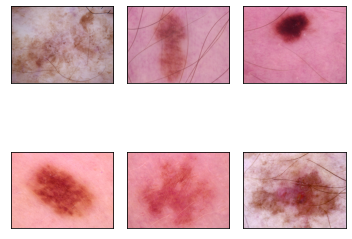

In [170]:
# visualize some sample images
w, h = 10, 10
fig = plt.figure(figsize=(5,5))
columns, rows = 3, 2
start, end = 0, len(imageid_path_dict)
ax = []
import random
for i in range(columns*rows):
    k = random.randint(start, end)
    img = mpimg.imread((all_image_path[k]))
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
plt.tight_layout()
plt.show()  

In [171]:
# Checking the size and number of channels in the image
arr = np.asarray(Image.open(all_image_path[10]))
arr.shape

(450, 600, 3)

In [172]:
# exploring the HAM10000_metadata
df_original = pd.read_csv(os.path.join(datadir, 'HAM10000_metadata.csv')) #read csv file
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)   # map image_id to its path
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)     # map dx to lesion type
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes  # assign class codes for lesion types


In [173]:
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2


In [174]:
print(f'Number of images: {len(df_original)}')

Number of images: 10015


In [175]:
# check class categories
df_original[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9803,0,Actinic keratoses
2909,1,Basal cell carcinoma
1017,2,Benign keratosis-like lesions
2198,3,Dermatofibroma
7509,4,Melanocytic nevi
2368,5,Vascular lesions


`cell_type_idx` will be used for model training. We can check distribution of images over these classes.

In [176]:
df_original['cell_type'].value_counts()

Melanocytic nevi                  6705
Dermatofibroma                    1228
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Name: cell_type, dtype: int64

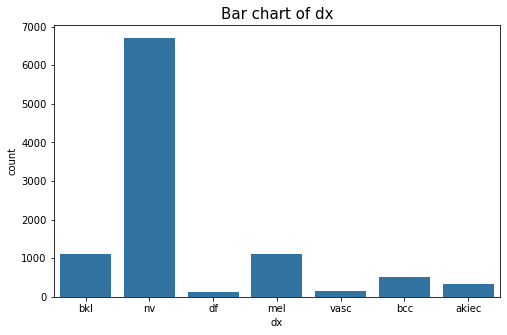

In [177]:
# Counts in each class
plt.figure(figsize=(8,5))
ax = sns.countplot(x='dx',data=df_original, color=colors[0])
plt.title('Bar chart of dx', fontdict={'size': 15})
plt.show()

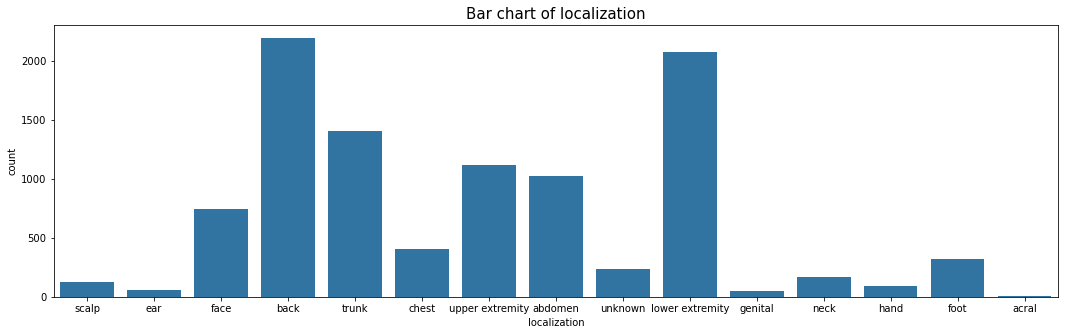

In [178]:
# Distribution of localization
plt.figure(figsize=(18,5))
ax = sns.countplot(x='localization',data=df_original, color=colors[0])
plt.title('Bar chart of localization', fontdict={'size': 15})
plt.show()

/home/nishita/anaconda3/envs/skin/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


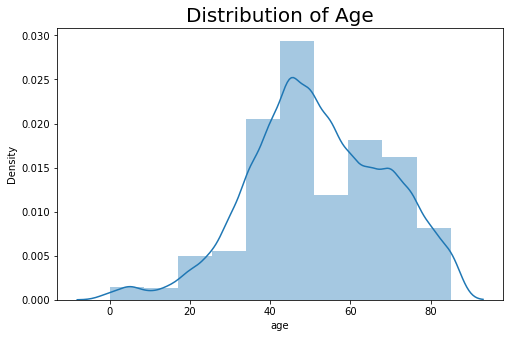

In [179]:
# Distribution of age
plt.figure(figsize=(8,5))
ax = sns.distplot(df_original['age'].dropna().values, 
                  bins=10, 
                  color=colors[0])
plt.title('Distribution of Age', fontdict={'size': 20})
plt.xlabel('age')
plt.show()

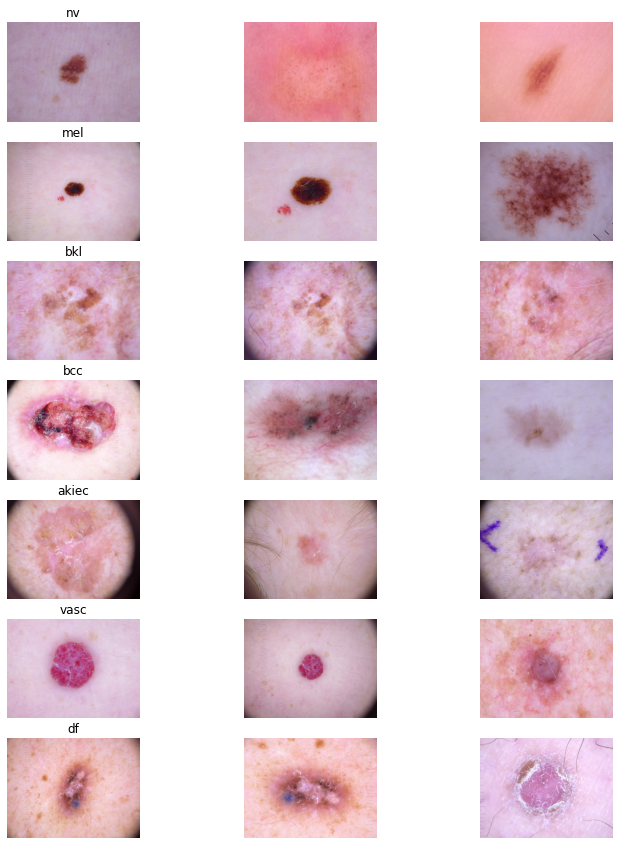

In [180]:
classes = df_original['dx'].value_counts() 
n_samples = 3

# Visualizing images from each class
fig, ax = plt.subplots(len(classes), n_samples, figsize = (4*n_samples, 15))
for i in range(len(classes)):
    cls, sub_df = classes.index[i], df_original.loc[df_original['dx']==classes.index[i]]
    ax[i][0].set_title(cls)
    for j in range(n_samples):
        img = cv2.imread(sub_df['path'].iloc[j])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        ax[i][j].imshow(img)
        ax[i][j].axis('off')

In [181]:
#Creating a new dataframe df_undup that contains only the non-duplicate elements.
df_undup = df_original.groupby('lesion_id').count()
df_undup.head()

,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
lesion_id,,,,,,,,,
HAM_0000000,2,2,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1,1,1


Some lesion_id's have more than 1 image associated with them. Let's separate the unduplicated ids

In [182]:
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()
len(df_undup)

5514

In [183]:
# Create new column specifying duplicated or not
def duplicated_or_not(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'
df_original['duplicates'] = df_original['lesion_id']
df_original['duplicates'] = df_original['duplicates'].apply(duplicated_or_not)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated


In [184]:
#creating the unduplicated dataframe
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,unduplicated
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,unduplicated
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,unduplicated
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,unduplicated
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,unduplicated


In [185]:
len(df_undup) 

5514

In [186]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

We need to split the 10015 images into training and validation set. The training set can contain duplicated images but not the validation set. Hence, we choose validation images from the unduplicated ids and the rest can go to the training set.

In [187]:
#Create the validation dataframe
labels = df_undup['cell_type_idx']  #labels
_, df_temp = train_test_split(df_undup, test_size=0.3, random_state=42, stratify=labels)
df_temp.shape

(1655, 11)

In [188]:
# Assign val or train status to lesion_ids

def get_val_rows(x): 
    val_list = list(df_temp['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


df_original['train_or_val'] = df_original['image_id']
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))

8360


In [189]:
df_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,duplicated,train


In [190]:
# Split the validation dataframe further to create test and val
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
df_val.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
9909,HAM_0005648,ISIC_0027580,akiec,histo,75.0,male,upper extremity,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Actinic keratoses,0,unduplicated
8703,HAM_0004942,ISIC_0028202,nv,histo,75.0,male,back,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Melanocytic nevi,4,unduplicated
7254,HAM_0003394,ISIC_0029405,nv,histo,25.0,male,genital,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Melanocytic nevi,4,unduplicated
5151,HAM_0003519,ISIC_0026627,nv,follow_up,55.0,male,lower extremity,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Melanocytic nevi,4,unduplicated
8034,HAM_0002597,ISIC_0033045,nv,consensus,25.0,male,unknown,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Melanocytic nevi,4,unduplicated


In [191]:
df_test.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
6498,HAM_0000157,ISIC_0032392,nv,follow_up,65.0,male,abdomen,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Melanocytic nevi,4,unduplicated
518,HAM_0001979,ISIC_0027527,bkl,histo,55.0,male,face,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Benign keratosis-like lesions,2,unduplicated
6399,HAM_0007222,ISIC_0030996,nv,follow_up,45.0,male,trunk,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Melanocytic nevi,4,unduplicated
6204,HAM_0000461,ISIC_0027750,nv,follow_up,30.0,female,abdomen,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Melanocytic nevi,4,unduplicated
5316,HAM_0007394,ISIC_0030864,nv,follow_up,45.0,female,trunk,/home/nishita/datasets/skin_mnist/HAM10000_ima...,Melanocytic nevi,4,unduplicated


In [192]:
df_test = df_test.reset_index()
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index()

In [194]:
df_train.shape

(8360, 12)

In [195]:
df_val.shape

(827, 12)

In [196]:
df_test.shape

(828, 12)

We now have three dataframes for train, val and test each with a 70/15/15% split. Validation and test set only have unduplicated images, training set has duplicated images as well.

In [207]:
df_train['cell_type_idx'].value_counts()

4    5380
3    1147
2     967
1     461
0     282
5     123
Name: cell_type_idx, dtype: int64

In [198]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  651
Benign keratosis-like lesions      71
Dermatofibroma                     47
Basal cell carcinoma               33
Actinic keratoses                  16
Vascular lesions                    9
Name: cell_type, dtype: int64

In [199]:
df_test['cell_type'].value_counts()

Melanocytic nevi                  674
Benign keratosis-like lesions      61
Dermatofibroma                     34
Actinic keratoses                  29
Basal cell carcinoma               20
Vascular lesions                   10
Name: cell_type, dtype: int64